In [1]:
!pip install -q opencv-python

In [2]:
!pip install tensorflow_hub


In [3]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

'wget' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'examples' already exists and is not an empty directory.


# load body part

In [5]:
# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [6]:
def detect(input_tensor, inference_count=3):
    image_height, image_width, channel = input_tensor.shape
    # Detect pose using the full input image
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)
    # Repeatedly using previous detection result to identify the region of
    # interest and only croping that region to improve detection accuracy
    for _ in range(inference_count - 1):
        person = movenet.detect(input_tensor.numpy(), reset_crop_region=False)
    return person

In [7]:
def draw_prediction_on_image(image, person, crop_region=None, close_figure=True,keep_input_size=False):
    # Draw the detection result on top of the image.
    image_np = utils.visualize(image, [person])

    # Plot the image with detection results.
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    im = ax.imshow(image_np)

    if close_figure:
        plt.close(fig)

    if not keep_input_size:
        image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

    return image_np

In [8]:
#@title Code to load the images, detect pose landmarks and save them into a CSV file

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]
        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path + '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

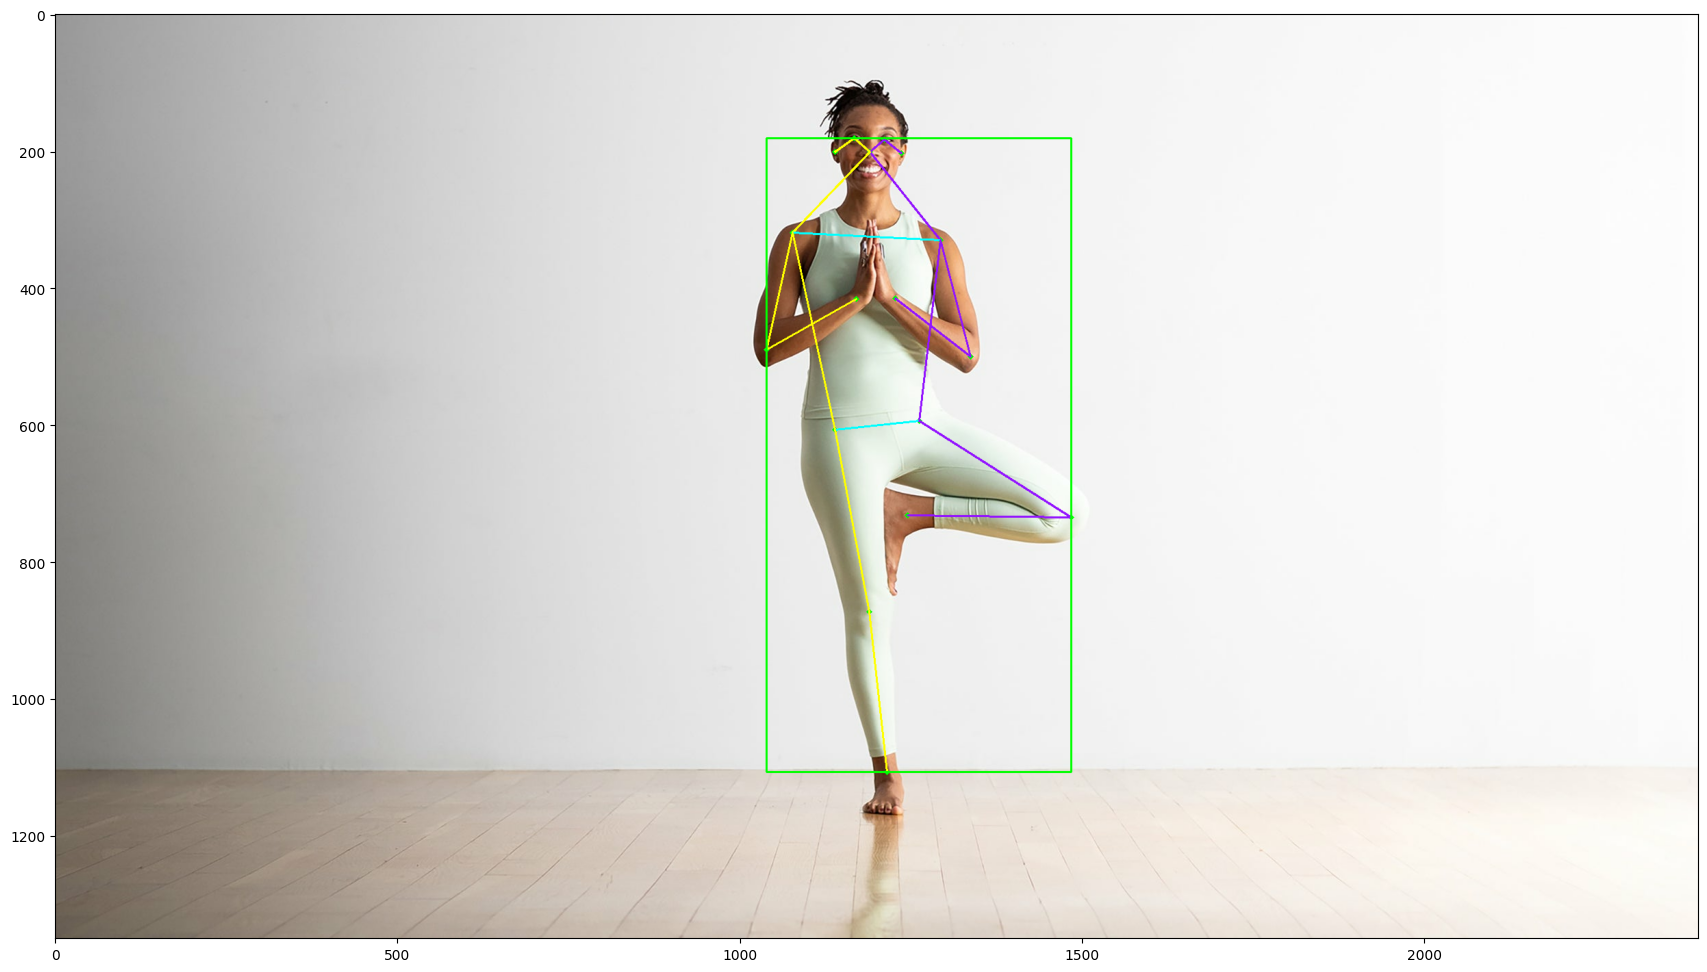

In [9]:

image = tf.io.read_file('treepose.jpg')
image = tf.io.decode_jpeg(image)
person = detect(image)
_ = draw_prediction_on_image(image.numpy(), person, crop_region=None, close_figure=False, keep_input_size=True)

In [12]:
person.keypoints

[KeyPoint(body_part=<BodyPart.NOSE: 0>, coordinate=Point(x=1190, y=201), score=0.78133374),
 KeyPoint(body_part=<BodyPart.LEFT_EYE: 1>, coordinate=Point(x=1211, y=183), score=0.8883766),
 KeyPoint(body_part=<BodyPart.RIGHT_EYE: 2>, coordinate=Point(x=1167, y=181), score=0.81098926),
 KeyPoint(body_part=<BodyPart.LEFT_EAR: 3>, coordinate=Point(x=1236, y=203), score=0.88476706),
 KeyPoint(body_part=<BodyPart.RIGHT_EAR: 4>, coordinate=Point(x=1139, y=201), score=0.8474771),
 KeyPoint(body_part=<BodyPart.LEFT_SHOULDER: 5>, coordinate=Point(x=1293, y=330), score=0.91179305),
 KeyPoint(body_part=<BodyPart.RIGHT_SHOULDER: 6>, coordinate=Point(x=1077, y=319), score=0.87221265),
 KeyPoint(body_part=<BodyPart.LEFT_ELBOW: 7>, coordinate=Point(x=1337, y=500), score=0.7985615),
 KeyPoint(body_part=<BodyPart.RIGHT_ELBOW: 8>, coordinate=Point(x=1039, y=490), score=0.94005287),
 KeyPoint(body_part=<BodyPart.LEFT_WRIST: 9>, coordinate=Point(x=1227, y=415), score=0.794294),
 KeyPoint(body_part=<BodyPart

In [13]:
min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
print(min_landmark_score)

0.68562853


In [14]:
pose_landmarks = np.array( [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]  for keypoint in person.keypoints], dtype=np.float32)
# Write the landmark coordinates to its per-class CSV file
coordinates = pose_landmarks.flatten().astype(str).tolist()
print(coordinates)

['1190.0', '201.0', '0.78133374', '1211.0', '183.0', '0.8883766', '1167.0', '181.0', '0.81098926', '1236.0', '203.0', '0.88476706', '1139.0', '201.0', '0.8474771', '1293.0', '330.0', '0.91179305', '1077.0', '319.0', '0.87221265', '1337.0', '500.0', '0.7985615', '1039.0', '490.0', '0.94005287', '1227.0', '415.0', '0.794294', '1170.0', '416.0', '0.68562853', '1262.0', '594.0', '0.92813724', '1139.0', '607.0', '0.90170646', '1484.0', '735.0', '0.91144484', '1189.0', '873.0', '0.87096536', '1245.0', '732.0', '0.70421433', '1215.0', '1107.0', '0.8527733']


In [15]:
is_skip_step_1 = False

In [16]:
use_custom_dataset = True

dataset_is_split = True

In [17]:
if use_custom_dataset:
  # ATTENTION:
  # You must edit these two lines to match your archive and images folder name:
  # !tar -xf YOUR_DATASET_ARCHIVE_NAME.tar
  
  dataset_in = 'yoga_poses'

  # You can leave the rest alone:
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

In [18]:
if not is_skip_step_1:
  images_in_train_folder = os.path.join(IMAGES_ROOT, 'TRAIN')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,)
  preprocessor.process(per_pose_class_limit=None)

Preprocessing chair
100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [03:34<00:00,  1.87it/s]
Preprocessing cobra
100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [03:07<00:00,  2.13it/s]
Preprocessing dog
100%|███████████████████████████████████████████████████████████████████████████████▋| 537/539 [04:12<00:01,  1.51it/s]C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [04:12<00:00,  2.13it/s]
Preprocessing no_pose
100%|███████████████████████████████████████████████████████████████████

Skipped yoga_poses\TRAIN\chair\girl3_chair087_flipped.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair088_flipped.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair089_flipped.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair091.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair091_flipped.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair092.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair092_flipped.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair093.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair093_flipped.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair094.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TRAIN\chair\girl3_chair095_flipped.jpg. No pose was confidentlly detected

In [19]:
if not is_skip_step_1:
  images_in_test_folder = os.path.join(IMAGES_ROOT, 'TEST')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,)

  preprocessor.process(per_pose_class_limit=None)

Preprocessing chair
100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:37<00:00,  1.72it/s]
Preprocessing cobra
100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [02:11<00:00,  1.77it/s]
Preprocessing dog
100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:27<00:00,  2.06it/s]
Preprocessing no_pose
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.31it/s]
Preprocessing shoudler_stand
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.11it/s]
Preprocessing traingle
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.06it/s]
Preprocessing tree
100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [01:29<00:00,  2.15it/s]
Preproces

Skipped yoga_poses\TEST\cobra\guy3_cobra036_flipped.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra048.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra050.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra051.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra051_flipped.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra052.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra053.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra054.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra055.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra056.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra057.jpg. No pose was confidentlly detected.
Skipped yoga_poses\TEST\cobra\guy3_cobra058.jpg. No pose was

In [33]:
import enum
from typing import List, NamedTuple

import numpy as np


class BodyPart(enum.Enum):
  """Enum representing human body keypoints detected by pose estimation models."""
  NOSE = 0
  LEFT_EYE = 1
  RIGHT_EYE = 2
  LEFT_EAR = 3
  RIGHT_EAR = 4
  LEFT_SHOULDER = 5
  RIGHT_SHOULDER = 6
  LEFT_ELBOW = 7
  RIGHT_ELBOW = 8
  LEFT_WRIST = 9
  RIGHT_WRIST = 10
  LEFT_HIP = 11
  RIGHT_HIP = 12
  LEFT_KNEE = 13
  RIGHT_KNEE = 14
  LEFT_ANKLE = 15
  RIGHT_ANKLE = 16


class Point(NamedTuple):
  """A point in 2D space."""
  x: float
  y: float


class Rectangle(NamedTuple):
  """A rectangle in 2D space."""
  start_point: Point
  end_point: Point


class KeyPoint(NamedTuple):
  """A detected human keypoint."""
  body_part: BodyPart
  coordinate: Point
  score: float


class Person(NamedTuple):
  """A pose detected by a pose estimation model."""
  keypoints: List[KeyPoint]
  bounding_box: Rectangle
  score: float
  id: int = None


def person_from_keypoints_with_scores(
    keypoints_with_scores: np.ndarray,
    image_height: float,
    image_width: float,
    keypoint_score_threshold: float = 0.1) -> Person:
  """Creates a Person instance from single pose estimation model output.

  Args:
    keypoints_with_scores: Output of the TFLite pose estimation model. A numpy
      array with shape [17, 3]. Each row represents a keypoint: [y, x, score].
    image_height: height of the image in pixels.
    image_width: width of the image in pixels.
    keypoint_score_threshold: Only use keypoints with above this threshold to
      calculate the person average score.

  Returns:
    A Person instance.
  """

  kpts_x = keypoints_with_scores[:, 1]
  kpts_y = keypoints_with_scores[:, 0]
  scores = keypoints_with_scores[:, 2]

  # Convert keypoints to the input image coordinate system.
  keypoints = []
  for i in range(scores.shape[0]):
    keypoints.append(
        KeyPoint(
            BodyPart(i),
            Point(int(kpts_x[i] * image_width), int(kpts_y[i] * image_height)),
            scores[i]))

  # Calculate bounding box as SinglePose models don't return bounding box.
  start_point = Point(
      int(np.amin(kpts_x) * image_width), int(np.amin(kpts_y) * image_height))
  end_point = Point(
      int(np.amax(kpts_x) * image_width), int(np.amax(kpts_y) * image_height))
  bounding_box = Rectangle(start_point, end_point)

  # Calculate person score by averaging keypoint scores.
  scores_above_threshold = list(
      filter(lambda x: x > keypoint_score_threshold, scores))
  person_score = np.average(scores_above_threshold)

  return Person(keypoints, bounding_box, person_score)


class Category(NamedTuple):
  """A classification category."""
  label: str
  score: float


In [34]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center

In [35]:
def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

    It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)
    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)
    return pose_size

In [36]:
def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size
    return landmarks

In [37]:
def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)
    return embedding

In [38]:
def preprocess_data(X_train):
    processed_X_train = []
    for i in range(X_train.shape[0]):
        embedding = landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X_train.iloc[i]), (1, 51)))
        processed_X_train.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X_train)

In [39]:
# loading final csv file
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(['file_name'],axis=1, inplace=True)
    classes = df.pop('class_name').unique()
    y = df.pop('class_no')
    
    X = df.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes

In [40]:
X, y, class_names = load_csv('train_data.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
X_test, y_test, _ = load_csv('test_data.csv')

In [41]:
processed_X_train = preprocess_data(X_train)
processed_X_val =  preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

In [54]:
inputs = tf.keras.Input(shape=(34))
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)
model = keras.Model(inputs, outputs)

In [55]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

In [56]:
# Start training
print('--------------TRAINING----------------')
print(processed_X_train)
history = model.fit(processed_X_train, y_train,
                    epochs=27,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

--------------TRAINING----------------
tf.Tensor(
[[-0.00729582 -0.32831195  0.00364791 ...  0.10578941 -0.00364791
   0.42680556]
 [-0.01680162 -0.35619438 -0.02352227 ...  0.32259113 -0.04368421
   0.30914983]
 [ 0.32414407  0.00214665  0.33702394 ... -0.06225283 -0.33273065
   0.01931985]
 ...
 [-0.00153374 -0.32208437  0.01687109 ...  0.42637837 -0.0260735
   0.09815905]
 [ 0.02637041 -0.24905385  0.01465023 ...  0.325235    0.00586009
   0.325235  ]
 [ 0.02434441 -0.2663565   0.02720846 ...  0.32936555 -0.08448942
   0.07446525]], shape=(1569, 34), dtype=float32)
Epoch 1/27
84/99 [========================>.....] - ETA: 0s - loss: 1.6614 - accuracy: 0.4159
Epoch 1: val_accuracy improved from -inf to 0.66065, saving model to weights.best.hdf5
99/99 [==============================] - 1s 4ms/step - loss: 1.6161 - accuracy: 0.4232 - val_loss: 1.2331 - val_accuracy: 0.6606
Epoch 2/27
72/99 [====================>.........] - ETA: 0s - loss: 1.1324 - accuracy: 0.5929

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/99 [===========================>..] - ETA: 0s - loss: 1.0952 - accuracy: 0.6053
Epoch 2: val_accuracy improved from 0.66065 to 0.72202, saving model to weights.best.hdf5
99/99 [==============================] - 0s 4ms/step - loss: 1.0908 - accuracy: 0.6087 - val_loss: 0.9080 - val_accuracy: 0.7220
Epoch 3/27
93/99 [===========================>..] - ETA: 0s - loss: 0.8528 - accuracy: 0.6942
Epoch 3: val_accuracy did not improve from 0.72202
99/99 [==============================] - 0s 3ms/step - loss: 0.8468 - accuracy: 0.6979 - val_loss: 0.7385 - val_accuracy: 0.7184
Epoch 4/27
78/99 [======================>.......] - ETA: 0s - loss: 0.7352 - accuracy: 0.7252
Epoch 4: val_accuracy improved from 0.72202 to 0.84116, saving model to weights.best.hdf5
99/99 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.7291 - val_loss: 0.5981 - val_accuracy: 0.8412
Epoch 5/27
93/99 [===========================>..] - ETA: 0s - loss: 0.6345 - accuracy: 0.7809
Epoch 5: val_accu

In [57]:
print('-----------------EVAUATION----------------')
loss, accuracy = model.evaluate(processed_X_test, y_test)
model.save('newmodel.h5')
print('LOSS: ', loss*100)
print("ACCURACY: ", accuracy*100)

-----------------EVAUATION----------------
28/28 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9886
LOSS:  4.117200896143913
ACCURACY:  98.85975122451782


28/28 [==============================] - 0s 1ms/step
Confusion matrix, without normalization

Classification Report:
                 precision    recall  f1-score   support

         chair       0.99      1.00      0.99       168
         cobra       0.99      1.00      1.00       194
           dog       1.00      1.00      1.00       169
       no_pose       0.00      0.00      0.00         2
shoudler_stand       1.00      0.88      0.93         8
      traingle       0.67      1.00      0.80        10
          tree       0.99      1.00      0.99       187
       warrior       1.00      0.95      0.97       139

      accuracy                           0.99       877
     macro avg       0.83      0.85      0.84       877
  weighted avg       0.99      0.99      0.99       877



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

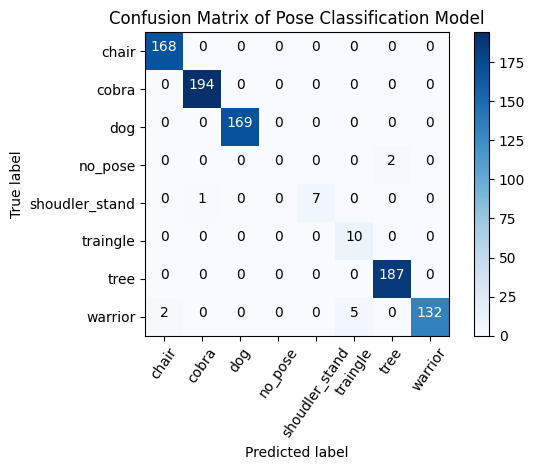

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(processed_X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [61]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(27)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

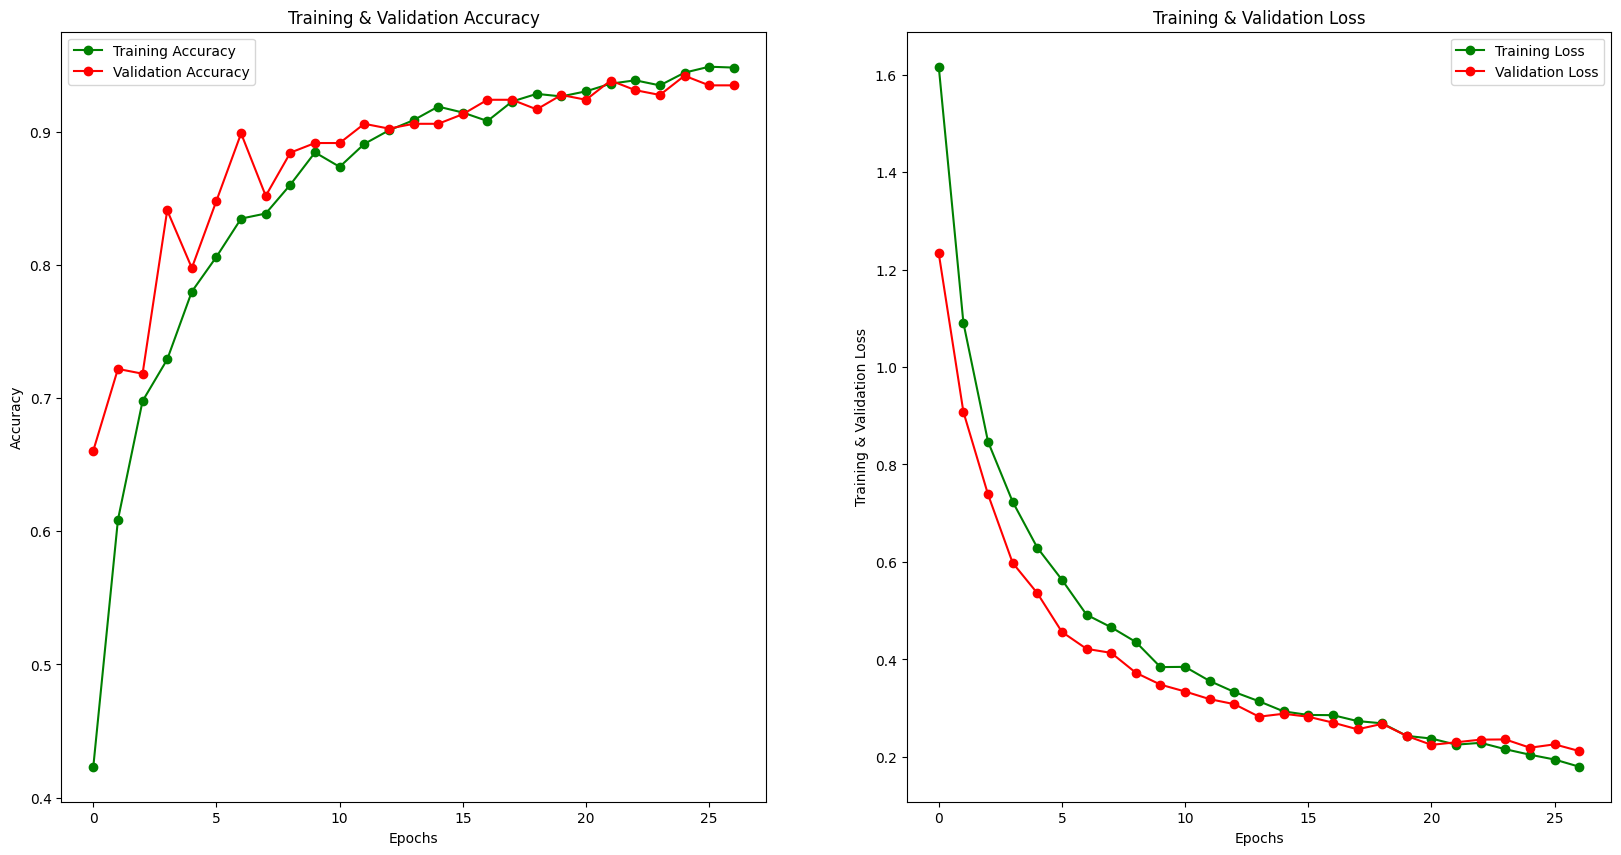

In [62]:
plot_accuracy_loss_chart(history)